In [0]:
%pip install jugaad_data

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.8/115.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.0.4
    Not uninstalling click at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-b4d09078-5135-4ed8-a606-2a961d1ddcf9
    Can't uninstall 'click'. No files were found to uninstall.
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.1
    Not uninstalling beautifulsoup4 at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-b4d09078-5135-4ed8-a606-2a961d1ddcf9
    Can't uninstall 'beautifulsoup4'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into 

In [0]:
%pip install hyperopt

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 10.7 MB/s eta 0:00:00
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492025 sha256=aad99288f0b93c941b34ef697f441066a559865e7b0441d0960189027201aa34
  Stored in directory: /root/.cache/pip/wheels/5e/a9/47/f118e66afd12240e4662752cc22cefae5d97275623aa8ef57d
Successfully built future
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
from datetime import date
from jugaad_data.nse import bhavcopy_save, bhavcopy_fo_save
from jugaad_data.nse import stock_df
from pyspark.sql import functions as f
from pyspark.sql.types import *
import pandas as pd

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from hyperopt import hp
from hyperopt import fmin, tpe, Trials
import numpy as np
import mlflow
import mlflow.spark

In [0]:
def get_historical_data(symbol="INFY"):
    df = stock_df(symbol=symbol, from_date=date(2005,1,1),
                to_date=date.today(), series="EQ")
    return df

In [0]:
"""
Features: 
'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',  'Is_year_end', and  'Is_year_start'.
"""
def feature_preparation(df):
    ndf = df[['DATE','CLOSE']]
    inputdf = spark.createDataFrame(ndf)
    inputdf = (inputdf 
            .selectExpr("cast(DATE as date) as DATE","CLOSE")
            .withColumn("Year",f.year(f.col("DATE")))
            .withColumn("Month",f.month(f.col("DATE")))
            .withColumn("Week",f.weekofyear(f.col("DATE")))
            .withColumn("Day",f.dayofmonth(f.col("DATE")))
            .withColumn("DayOfYear",f.dayofyear(f.col("DATE")))
            .withColumn("DayOfWeek",f.dayofweek(f.col("DATE")))
            .withColumn("is_month_end",f.last_day(f.col("DATE"))).withColumn("is_month_end", f.when(f.col("DATE")==f.col("is_month_end"),1).otherwise(0))
            .withColumn("is_month_start",f.trunc(f.col("DATE"),"month")).withColumn("is_month_start", f.when(f.col("DATE")==f.col("is_month_start"),1).otherwise(0))
            .withColumn("is_quarter_start",f.trunc(f.col("DATE"),"quarter")).withColumn("is_quarter_start", f.when(f.col("DATE")==f.col("is_quarter_start"),1).otherwise(0))
            .withColumn("is_quarter_end",f.date_sub(f.add_months(f.trunc(f.col("DATE"),"quarter"),3),1)).withColumn("is_quarter_end", f.when(f.col("DATE")==f.col("is_quarter_end"),1).otherwise(0))
            .withColumn("is_year_start",f.trunc(f.col("DATE"),"year")).withColumn("is_year_start", f.when(f.col("DATE")==f.col("is_year_start"),1).otherwise(0))
            .withColumn("is_year_end",f.date_sub(f.trunc(f.col("DATE"),"year"),1)).withColumn("is_year_end", f.when(f.col("DATE")==f.col("is_year_end"),1).otherwise(0))
            .withColumn("is_first_last_day",f.when(f.col("DayOfWeek").isin([1,5]),1).otherwise(0))
            ).drop("DATE")
    return inputdf

In [0]:
def build_pipeline_model(train_df):
    numeric_cols = [field for (field, dataType) in train_df.dtypes if ((dataType == "int") & (field != "CLOSE"))]
    vec_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
    rf = RandomForestRegressor(labelCol="CLOSE", maxBins=40, seed=42)
    pipeline = Pipeline(stages=[vec_assembler, rf])
    return pipeline

In [0]:
# HyperOpt tuning - STEP-1
def objective_function(params):  
    """
    An input params including hyperparameter values to use when training the model
    An output containing a loss metric on which to optimize
    """  
    # set the hyperparameters that we want to tune
    max_depth = params["max_depth"]
    num_trees = params["num_trees"]
    pipeline = build_pipeline_model(train_df)

    with mlflow.start_run():
        estimator = pipeline.copy({rf.maxDepth: max_depth, rf.numTrees: num_trees})
        model = estimator.fit(train_df)

        preds = model.transform(val_df)

        r2_regression_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="CLOSE", metricName="r2")
        rmse = regression_evaluator.evaluate(preds)
        r2 = r2_regression_evaluator.evaluate(preds)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("rmse", r2)

    return rmse

#STEP-2
# This is similar to the parameter grid in a grid search process. However, we are only specifying the range of values rather than the individual, specific values to be tested. It's up to hyperopt's optimization algorithm to choose the actual values.
def search_space():
    return {
    "max_depth": hp.quniform("max_depth", 2, 5, 1),
    "num_trees": hp.quniform("num_trees", 10, 100, 1)
    }

In [0]:
def get_best_hyper_param(search_space,num_evals,trials):
    best_hyperparam = fmin(fn=objective_function, 
                       space=search_space,
                       algo=tpe.suggest, # algo for hyperopt 
                       max_evals=num_evals,
                       trials=trials,
                       rstate=np.random.default_rng(42))
    return best_hyperparam

## Regiter model to MLFLOW

In [0]:
def register_model(run_id):
    """
    This function will register the model to ml flow registry. With model_details object we can move to different stages, and update models
    """
    model_uri = f"runs:/{run_id}/model"

    suffix = "stock_prediction"
    model_name = f"mllib-_{suffix}_{symbol}"
    print(f"Model Name: {model_name}\n")
    model_details = mlflow.register_model(model_uri=model_uri, name=model_name)
    return model_details

In [0]:
def register_to_mlflow(best_hyperparam):
    run_name = f"stock_prediction_{symbol}"
    print("-----------",run_name)
    with mlflow.start_run(run_name=run_name) as run:
        # STEP-4
        best_max_depth = best_hyperparam["max_depth"]
        best_num_trees = best_hyperparam["num_trees"]
        pipeline = build_pipeline_model(train_df)
        
        estimator = pipeline.copy({rf.maxDepth: best_max_depth, rf.numTrees: best_num_trees})
        combined_df = train_df.union(val_df) # Combine train & validation together
        

        pipeline_model = estimator.fit(combined_df)
        pred_df = pipeline_model.transform(test_df)

        rmse = regression_evaluator.evaluate(pred_df)

        r2_regression_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="CLOSE", metricName="r2")
        r2 = r2_regression_evaluator.evaluate(pred_df)

        # Log param and metrics for the final model
        mlflow.log_param("maxDepth", best_max_depth)
        mlflow.log_param("numTrees", best_num_trees)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.spark.log_model(pipeline_model, "model")
        run_id = run.info.run_id
        return register_model(run_id)

In [0]:
if __name__=="__main__":
    global symbol
    symbol = "INFY"
    df = get_historical_data(symbol)
    input_df = feature_preparation(df)
    global train_df,val_df,test_df, rf,regression_evaluator
    train_df, val_df, test_df = input_df.randomSplit([.6, .2, .2], seed=42)
    rf = RandomForestRegressor(labelCol="CLOSE", maxBins=40, seed=42)
    regression_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="CLOSE", metricName="rmse")
    

    # hyperopt tuning
    num_evals = 4 # total number of models to be built
    trials = Trials() # model value will be stored here. Based on that hyperopt decide the best param
    #search_space = search_space()
    search_space = {
    "max_depth": hp.quniform("max_depth", 2, 5, 1),
    "num_trees": hp.quniform("num_trees", 10, 100, 1)
    }

    best_hyperparam = get_best_hyper_param(search_space, num_evals, trials)

    #mlflow
    model_details = register_to_mlflow(best_hyperparam)
    print(model_details)

100%|██████████| 4/4 [00:24<00:00,  6.22s/trial, best loss: 388.0588758821124]
----------- stock_prediction_INFY


2023/12/17 08:37:42 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
/databricks/python/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model Name: mllib-_stock_prediction_INFY



Registered model 'mllib-_stock_prediction_INFY' already exists. Creating a new version of this model...
2023/12/17 08:38:26 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: mllib-_stock_prediction_INFY, version 3


<ModelVersion: creation_timestamp=1702802306029, current_stage='None', description='', last_updated_timestamp=1702802311189, name='mllib-_stock_prediction_INFY', run_id='c6c585fd687b4b96874202bbf17b3e46', run_link='', source='dbfs:/databricks/mlflow-tracking/1080235385731634/c6c585fd687b4b96874202bbf17b3e46/artifacts/model', status='READY', status_message='', tags={}, user_id='gopinath.chandrasekaran@databricks.com', version='3'>


Created version '3' of model 'mllib-_stock_prediction_INFY'.


## Predict for future dates

In [0]:
def regression_evaluate(pred_df):
    """
    Check the accuracy of the predicted df. 
    A good model have low RMSE value and r2 value as 1. R2 ranges from 0-1. 0 means no value in model
    """
    regression_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="CLOSE", metricName="rmse")

    rmse = regression_evaluator.evaluate(pred_df)
    r2 = regression_evaluator.setMetricName("r2").evaluate(pred_df)
    print(f"RMSE is {rmse}")
    print(f"R2 is {r2}")

def predict(future_df,symbol):
    model_name = f"stock_prediction_{symbol}"
    run_id = mlflow.search_runs(filter_string=f"run_name='{model_name}'")['run_id'][0] # add logic to get the best run
    logged_model = f"runs:/{run_id}/model"
    loaded_model = mlflow.spark.load_model(logged_model)

    pred_df = loaded_model.transform(future_df)
    regression_evaluate(pred_df)
    return pred_df

In [0]:
model_name = f"stock_prediction_{symbol}"
run_id = mlflow.search_runs(filter_string=f"run_name='{model_name}'")['run_id'][0]
print(run_id)

c6c585fd687b4b96874202bbf17b3e46


In [0]:
def get_future_data():
    df = pd.DataFrame(pd.date_range(start='2023-08-10', end='2025-01-31'), columns=['DATE'])
    df["CLOSE"] = 2000 # dummy value
    inputdf = feature_preparation(df)
    return inputdf

In [0]:
display(get_future_data())

CLOSE Year Month Week Day DayOfYear DayOfWeek is_month_end is_month_start is_quarter_start is_quarter_end is_year_start is_year_end is_first_last_day 2000 2023 8 32 10 222 5 0 0 0 0 0 0 1 2000 2023 8 32 11 223 6 0 0 0 0 0 0 0 2000 2023 8 32 12 224 7 0 0 0 0 0 0 0 2000 2023 8 32 13 225 1 0 0 0 0 0 0 1 2000 2023 8 33 14 226 2 0 0 0 0 0 0 0 2000 2023 8 33 15 227 3 0 0 0 0 0 0 0 2000 2023 8 33 16 228 4 0 0 0 0 0 0 0 2000 2023 8 33 17 229 5 0 0 0 0 0 0 1 2000 2023 8 33 18 230 6 0 0 0 0 0 0 0 2000 2023 8 33 19 231 7 0 0 0 0 0 0 0 2000 2023 8 33 20 232 1 0 0 0 0 0 0 1 2000 2023 8 34 21 233 2 0 0 0 0 0 0 0 2000 2023 8 34 22 234 3 0 0 0 0 0 0 0 2000 2023 8 34 23 235 4 0 0 0 0 0 0 0 2000 2023 8 34 24 236 5 0 0 0 0 0 0 1 2000 2023 8 34 25 237 6 0 0 0 0 0 0 0 2000 2023 8 34 26 238 7 0 0 0 0 0 0 0 2000 2023 8 34 27 239 1 0 0 0 0 0 0 1 2000 2023 8 35 28 240 2 0 0 0 0 0 0 0 2000 2023 8 35 29 241 3 0 0 0 0 0 0 0 2000 2023 8 35 30 242 4 0 0 0 0 0 0 0 2000 2023 8 35 31 243 5 1 0 0 0 0 0 1 2000 2023 9 35 1 244 6 0 1 0 0 0 0 0 2000 2023 9 35 2 245 7 0 0 0 0 0 0 0 2000 2023 9 35 3 246 1 0 0 0 0 0 0 1 2000 2023 9 36 4 247 2 0 0 0 0 0 0 0 2000 2023 9 36 5 248 3 0 0 0 0 0 0 0 2000 2023 9 36 6 249 4 0 0 0 0 0 0 0 2000 2023 9 36 7 250 5 0 0 0 0 0 0 1 2000 2023 9 36 8 251 6 0 0 0 0 0 0 0 2000 2023 9 36 9 252 7 0 0 0 0 0 0 0 2000 2023 9 36 10 253 1 0 0 0 0 0 0 1 2000 2023 9 37 11 254 2 0 0 0 0 0 0 0 2000 2023 9 37 12 255 3 0 0 0 0 0 0 0 2000 2023 9 37 13 256 4 0 0 0 0 0 0 0 2000 2023 9 37 14 257 5 0 0 0 0 0 0 1 2000 2023 9 37 15 258 6 0 0 0 0 0 0 0 2000 2023 9 37 16 259 7 0 0 0 0 0 0 0 2000 2023 9 37 17 260 1 0 0 0 0 0 0 1 2000 2023 9 38 18 261 2 0 0 0 0 0 0 0 2000 2023 9 38 19 262 3 0 0 0 0 0 0 0 2000 2023 9 38 20 263 4 0 0 0 0 0 0 0 2000 2023 9 38 21 264 5 0 0 0 0 0 0 1 2000 2023 9 38 22 265 6 0 0 0 0 0 0 0 2000 2023 9 38 23 266 7 0 0 0 0 0 0 0 2000 2023 9 38 24 267 1 0 0 0 0 0 0 1 2000 2023 9 39 25 268 2 0 0 0 0 0 0 0 2000 2023 9 39 26 269 3 0 0 0 0 0 0 0 2000 2023 9 39 27 270 4 0 0 0 0 0 0 0 2000 2023 9 39 28 271 5 0 0 0 0 0 0 1 2000 2023 9 39 29 272 6 0 0 0 0 0 0 0 2000 2023 9 39 30 273 7 1 0 0 1 0 0 0 2000 2023 10 39 1 274 1 0 1 1 0 0 0 1 2000 2023 10 40 2 275 2 0 0 0 0 0 0 0 2000 2023 10 40 3 276 3 0 0 0 0 0 0 0 2000 2023 10 40 4 277 4 0 0 0 0 0 0 0 2000 2023 10 40 5 278 5 0 0 0 0 0 0 1 2000 2023 10 40 6 279 6 0 0 0 0 0 0 0 2000 2023 10 40 7 280 7 0 0 0 0 0 0 0 2000 2023 10 40 8 281 1 0 0 0 0 0 0 1 2000 2023 10 41 9 282 2 0 0 0 0 0 0 0 2000 2023 10 41 10 283 3 0 0 0 0 0 0 0 2000 2023 10 41 11 284 4 0 0 0 0 0 0 0 2000 2023 10 41 12 285 5 0 0 0 0 0 0 1 2000 2023 10 41 13 286 6 0 0 0 0 0 0 0 2000 2023 10 41 14 287 7 0 0 0 0 0 0 0 2000 2023 10 41 15 288 1 0 0 0 0 0 0 1 2000 2023 10 42 16 289 2 0 0 0 0 0 0 0 2000 2023 10 42 17 290 3 0 0 0 0 0 0 0 2000 2023 10 42 18 291 4 0 0 0 0 0 0 0 2000 2023 10 42 19 292 5 0 0 0 0 0 0 1 2000 2023 10 42 20 293 6 0 0 0 0 0 0 0 2000 2023 10 42 21 294 7 0 0 0 0 0 0 0 2000 2023 10 42 22 295 1 0 0 0 0 0 0 1 2000 2023 10 43 23 296 2 0 0 0 0 0 0 0 2000 2023 10 43 24 297 3 0 0 0 0 0 0 0 2000 2023 10 43 25 298 4 0 0 0 0 0 0 0 2000 2023 10 43 26 299 5 0 0 0 0 0 0 1 2000 2023 10 43 27 300 6 0 0 0 0 0 0 0 2000 2023 10 43 28 301 7 0 0 0 0 0 0 0 2000 2023 10 43 29 302 1 0 0 0 0 0 0 1 2000 2023 10 44 30 303 2 0 0 0 0 0 0 0 2000 2023 10 44 31 304 3 1 0 0 0 0 0 0 2000 2023 11 44 1 305 4 0 1 0 0 0 0 0 2000 2023 11 44 2 306 5 0 0 0 0 0 0 1 2000 2023 11 44 3 307 6 0 0 0 0 0 0 0 2000 2023 11 44 4 308 7 0 0 0 0 0 0 0 2000 2023 11 44 5 309 1 0 0 0 0 0 0 1 2000 2023 11 45 6 310 2 0 0 0 0 0 0 0 2000 2023 11 45 7 311 3 0 0 0 0 0 0 0 2000 2023 11 45 8 312 4 0 0 0 0 0 0 0 2000 2023 11 45 9 313 5 0 0 0 0 0 0 1 2000 2023 11 45 10 314 6 0 0 0 0 0 0 0 2000 2023 11 45 11 315 7 0 0 0 0 0 0 0 2000 2023 11 45 12 316 1 0 0 0 0 0 0 1 2000 2023 11 46 13 317 2 0 0 0 0 0 0 0 2000 2023 11 46 14 318 3 0 0 0 0 0 0 0 2000 2023 11 46 15 319 4 0 0 0 0 0 0 0 2000 2023 11 46 16 320 5 0 0 0 0 0 0 1 2000 2023 11 46 17 321 6 0 0 0 0 0 0 0 2000 2023 11 46 18 322 7 0 0 

In [0]:
df = get_future_data()
pred_df = predict(df,"INFY")
display(pred_df)

2023/12/17 08:39:22 INFO mlflow.spark: 'runs:/c6c585fd687b4b96874202bbf17b3e46/model' resolved as 'dbfs:/databricks/mlflow-tracking/1080235385731634/c6c585fd687b4b96874202bbf17b3e46/artifacts/model'


RMSE is 581.854771407209
R2 is -inf


CLOSE Year Month Week Day DayOfYear DayOfWeek is_month_end is_month_start is_quarter_start is_quarter_end is_year_start is_year_end is_first_last_day features prediction 2000 2023 8 32 10 222 5 0 0 0 0 0 0 1 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5, 12), values -> List(2023.0, 8.0, 32.0, 10.0, 222.0, 5.0, 1.0)) 1367.3932879523886 2000 2023 8 32 11 223 6 0 0 0 0 0 0 0 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5), values -> List(2023.0, 8.0, 32.0, 11.0, 223.0, 6.0)) 1356.9471331513523 2000 2023 8 32 12 224 7 0 0 0 0 0 0 0 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5), values -> List(2023.0, 8.0, 32.0, 12.0, 224.0, 7.0)) 1566.4706059373118 2000 2023 8 32 13 225 1 0 0 0 0 0 0 1 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5, 12), values -> List(2023.0, 8.0, 32.0, 13.0, 225.0, 1.0, 1.0)) 1419.63541813589 2000 2023 8 33 14 226 2 0 0 0 0 0 0 0 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5), values -> List(2023.0, 8.0, 33.0, 14.0, 226.0, 2.0)) 1393.310419416642 2000 2023 8 33 15 227 3 0 0 0 0 0 0 0 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5), values -> List(2023.0, 8.0, 33.0, 15.0, 227.0, 3.0)) 1355.676310464262 2000 2023 8 33 16 228 4 0 0 0 0 0 0 0 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5), values -> List(2023.0, 8.0, 33.0, 16.0, 228.0, 4.0)) 1370.2885662218378 2000 2023 8 33 17 229 5 0 0 0 0 0 0 1 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5, 12), values -> List(2023.0, 8.0, 33.0, 17.0, 229.0, 5.0, 1.0)) 1365.860099380488 2000 2023 8 33 18 230 6 0 0 0 0 0 0 0 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5), values -> List(2023.0, 8.0, 33.0, 18.0, 230.0, 6.0)) 1336.7269726976235 2000 2023 8 33 19 231 7 0 0 0 0 0 0 0 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5), values -> List(2023.0, 8.0, 33.0, 19.0, 231.0, 7.0)) 1549.0585734471995 2000 2023 8 33 20 232 1 0 0 0 0 0 0 1 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5, 12), values -> List(2023.0, 8.0, 33.0, 20.0, 232.0, 1.0, 1.0)) 1416.8272901722735 2000 2023 8 34 21 233 2 0 0 0 0 0 0 0 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5), values -> List(2023.0, 8.0, 34.0, 21.0, 233.0, 2.0)) 1408.2772295499797 2000 2023 8 34 22 234 3 0 0 0 0 0 0 0 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5), values -> List(2023.0, 8.0, 34.0, 22.0, 234.0, 3.0)) 1370.6431205976 2000 2023 8 34 23 235 4 0 0 0 0 0 0 0 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5), values -> List(2023.0, 8.0, 34.0, 23.0, 235.0, 4.0)) 1395.7099442302294 2000 2023 8 34 24 236 5 0 0 0 0 0 0 1 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5, 12), values -> List(2023.0, 8.0, 34.0, 24.0, 236.0, 5.0, 1.0)) 1391.28147738888 2000 2023 8 34 25 237 6 0 0 0 0 0 0 0 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5), values -> List(2023.0, 8.0, 34.0, 25.0, 237.0, 6.0)) 1366.1646056648433 2000 2023 8 34 26 238 7 0 0 0 0 0 0 0 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5), values -> List(2023.0, 8.0, 34.0, 26.0, 238.0, 7.0)) 1521.6993278571254 2000 2023 8 34 27 239 1 0 0 0 0 0 0 1 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5, 12), values -> List(2023.0, 8.0, 34.0, 27.0, 239.0, 1.0, 1.0)) 1443.3314362957967 2000 2023 8 35 28 240 2 0 0 0 0 0 0 0 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5), values -> List(2023.0, 8.0, 35.0, 28.0, 240.0, 2.0)) 1417.0064375765487 2000 2023 8 35 29 241 3 0 0 0 0 0 0 0 Map(vectorType -> sparse, length -> 13, indices -> List(0, 1, 2, 3, 4, 5), values -> List(2023.0, 8.0, 35.0, 29.0, 241.0, 3.0)) 1379.3723286241689 2000 2023 8 35 30 242 4 0 0 0 0 0 0 0 Map(vectorType -> sparse, length -> 13, indices 

In [0]:
pred_val_df = pred_df.withColumn("_date",f.concat_ws("-",f.col("Year"),f.col("Month"),f.col("Day"))).withColumn("Date",f.col("_date").cast("date")).select("Date","prediction","CLOSE")
f1df = pred_val_df.toPandas()

Out[48]: [<matplotlib.lines.Line2D at 0x7fa1da00fb50>]

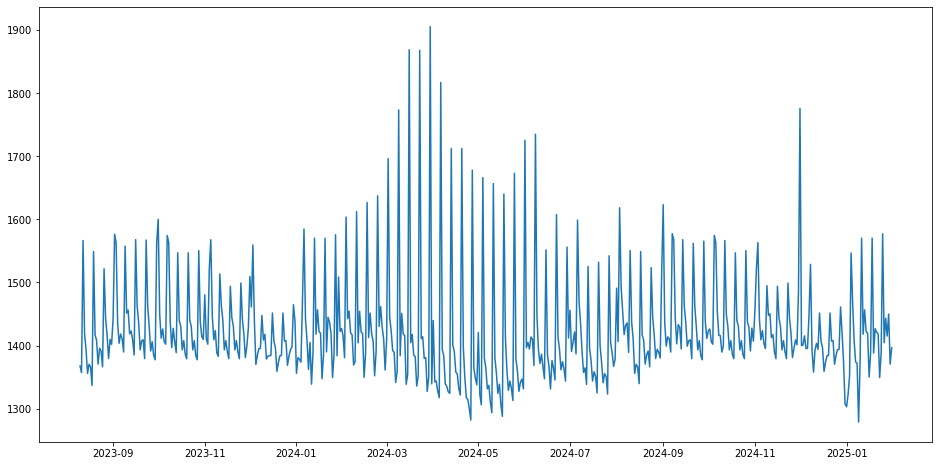

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

f1df.index = f1df['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(f1df['prediction'], label='Predicted_prices')

In [0]:
display(pred_val_df.select('Date','prediction'))

Date prediction 2023-08-10 1367.3932879523886 2023-08-11 1356.9471331513523 2023-08-12 1566.4706059373118 2023-08-13 1419.63541813589 2023-08-14 1393.310419416642 2023-08-15 1355.676310464262 2023-08-16 1370.2885662218378 2023-08-17 1365.860099380488 2023-08-18 1336.7269726976235 2023-08-19 1549.0585734471995 2023-08-20 1416.8272901722735 2023-08-21 1408.2772295499797 2023-08-22 1370.6431205976 2023-08-23 1395.7099442302294 2023-08-24 1391.28147738888 2023-08-25 1366.1646056648433 2023-08-26 1521.6993278571254 2023-08-27 1443.3314362957967 2023-08-28 1417.0064375765487 2023-08-29 1379.3723286241689 2023-08-30 1409.7304483556707 2023-08-31 1401.87666306194 2023-09-01 1441.9795815484258 2023-09-02 1576.578501953038 2023-09-03 1562.9627624317957 2023-09-04 1436.6927734193862 2023-09-05 1403.6092589687803 2023-09-06 1418.2215147263562 2023-09-07 1410.8524409077506 2023-09-08 1389.6374819761309 2023-09-09 1557.6139656069904 2023-09-10 1451.3335989838502 2023-09-11 1456.1517115902707 2023-09-12 1418.5176026378908 2023-09-13 1423.1214729319204 2023-09-14 1409.0970186414527 2023-09-15 1384.9414527325769 2023-09-16 1567.9447028338413 2023-09-17 1462.8723373968544 2023-09-18 1436.5473386776061 2023-09-19 1393.0859998419176 2023-09-20 1407.6982555994932 2023-09-21 1409.0970186414527 2023-09-22 1379.114222849268 2023-09-23 1567.2699729505325 2023-09-24 1462.8723373968544 2023-09-25 1430.7201087942974 2023-09-26 1391.3606399934329 2023-09-27 1405.9728957510083 2023-09-28 1384.1284141121166 2023-09-29 1377.3888630007832 2023-09-30 1562.7666378024276 2023-10-01 1600.0621246223402 2023-10-02 1449.165266238074 2023-10-03 1411.5311572856942 2023-10-04 1426.14341304327 2023-10-05 1405.9089189288966 2023-10-06 1402.1099747948188 2023-10-07 1574.6127084256786 2023-10-08 1563.2615486086681 2023-10-09 1438.6890942694436 2023-10-10 1396.8115288363701 2023-10-11 1427.3026285121578 2023-10-12 1405.458146873266 2023-10-13 1388.710210298386 2023-10-14 1546.9874729505323 2023-10-15 1439.6290927160032 2023-10-16 1430.7201087942974 2023-10-17 1393.0859998419176 2023-10-18 1407.6982555994932 2023-10-19 1385.8537739606015 2023-10-20 1379.114222849268 2023-10-21 1546.9874729505323 2023-10-22 1439.6290927160032 2023-10-23 1430.7201087942974 2023-10-24 1393.0859998419176 2023-10-25 1407.6982555994932 2023-10-26 1384.1284141121166 2023-10-27 1377.3888630007832 2023-10-28 1550.4146131020475 2023-10-29 1437.9037328675186 2023-10-30 1414.0000397860176 2023-10-31 1409.6000163646925 2023-11-01 1480.385353264729 2023-11-02 1410.389739824419 2023-11-03 1402.1099747948188 2023-11-04 1521.6152084256787 2023-11-05 1567.7423695041905 2023-11-06 1446.6851161086624 2023-11-07 1409.0510071562826 2023-11-08 1423.6632629138583 2023-11-09 1388.3322287228286 2023-11-10 1382.8397518437207 2023-11-11 1513.5943458631968 2023-11-12 1463.7142865241901 2023-11-13 1440.3160962434154 2023-11-14 1393.0859998419176 2023-11-15 1407.6982555994932 2023-11-16 1390.334594856124 2023-11-17 1379.114222849268 2023-11-18 1493.9899729505323 2023-11-19 1444.1099136115258 2023-11-20 1430.7201087942974 2023-11-21 1393.0859998419176 2023-11-22 1407.6982555994932 2023-11-23 1390.334594856124 2023-11-24 1379.114222849268 2023-11-25 1499.1424729505325 2023-11-26 1442.384553763041 2023-11-27 1418.4958516932506 2023-11-28 1380.8617427408708 2023-11-29 1398.9603377841609 2023-11-30 1428.1723314726491 2023-12-01 1509.3105218541662 2023-12-02 1461.1981245087786 2023-12-03 1559.403259969354 2023-12-04 1438.346006573826 2023-12-05 1369.986772621446 2023-12-06 1384.5990283790218 2023-12-07 1395.0482262189944 2023-12-08 1395.3941834116163 2023-12-09 1447.6504430424761 2023-12-10 1408.7712080711422 2023-12-11 1417.6521807658753 2023-12-12 1378.4462594313247 2023-12-13 1383.0501297253543 2023-12-14 1383.9033401162085 2023-12-15 1384.2492973088306 2023-12-16 1451.5323234100952 2023-12-17 1406.9251933110127 2023-12-18 1396.4759954710403 2023-12-19 1358.8418865186604 2023-12-20 1373.454142276236 2023-12-21 1383.903340116

Databricks visualization. Run in Databricks to view.

##----------------------- END ------------------------- ##

## Feature store testing

In [0]:
def get_historical_data(symbol="INFY"):
    df = stock_df(symbol=symbol, from_date=date(2005,1,1),
                to_date=date.today(), series="EQ")
    return df

In [0]:
df = get_historical_data()
input_df = feature_preparation(df)

In [0]:
input_df.display()

CLOSE Year Month Week Day DayOfYear DayOfWeek is_month_end is_month_start is_quarter_start is_quarter_end is_year_start is_year_end is_first_last_day 1578.4 2023 12 50 15 349 6 0 0 0 0 0 0 0 1501.45 2023 12 50 14 348 5 0 0 0 0 0 0 1 1449.0 2023 12 50 13 347 4 0 0 0 0 0 0 0 1476.05 2023 12 50 12 346 3 0 0 0 0 0 0 0 1488.5 2023 12 50 11 345 2 0 0 0 0 0 0 0 1491.15 2023 12 49 8 342 6 0 0 0 0 0 0 0 1465.9 2023 12 49 7 341 5 0 0 0 0 0 0 1 1474.3 2023 12 49 6 340 4 0 0 0 0 0 0 0 1453.95 2023 12 49 5 339 3 0 0 0 0 0 0 0 1464.35 2023 12 49 4 338 2 0 0 0 0 0 0 0 1452.3 2023 12 48 1 335 6 0 1 0 0 0 0 0 1455.15 2023 11 48 30 334 5 1 0 0 0 0 0 1 1459.6 2023 11 48 29 333 4 0 0 0 0 0 0 0 1442.7 2023 11 48 28 332 3 0 0 0 0 0 0 0 1437.4 2023 11 47 24 328 6 0 0 0 0 0 0 0 1449.25 2023 11 47 23 327 5 0 0 0 0 0 0 1 1457.8 2023 11 47 22 326 4 0 0 0 0 0 0 0 1439.0 2023 11 47 21 325 3 0 0 0 0 0 0 0 1436.6 2023 11 47 20 324 2 0 0 0 0 0 0 0 1437.55 2023 11 46 17 321 6 0 0 0 0 0 0 0 1444.9 2023 11 46 16 320 5 0 0 0 0 0 0 1 1410.5 2023 11 46 15 319 4 0 0 0 0 0 0 0 1373.55 2023 11 46 13 317 2 0 0 0 0 0 0 0 1388.2 2023 11 45 12 316 1 0 0 0 0 0 0 1 1368.85 2023 11 45 10 314 6 0 0 0 0 0 0 0 1374.8 2023 11 45 9 313 5 0 0 0 0 0 0 1 1391.0 2023 11 45 8 312 4 0 0 0 0 0 0 0 1404.3 2023 11 45 7 311 3 0 0 0 0 0 0 0 1403.3 2023 11 45 6 310 2 0 0 0 0 0 0 0 1389.05 2023 11 44 3 307 6 0 0 0 0 0 0 0 1370.15 2023 11 44 2 306 5 0 0 0 0 0 0 1 1354.15 2023 11 44 1 305 4 0 1 0 0 0 0 0 1368.4 2023 10 44 31 304 3 1 0 0 0 0 0 0 1377.05 2023 10 44 30 303 2 0 0 0 0 0 0 0 1380.35 2023 10 43 27 300 6 0 0 0 0 0 0 0 1359.45 2023 10 43 26 299 5 0 0 0 0 0 0 1 1370.05 2023 10 43 25 298 4 0 0 0 0 0 0 0 1408.65 2023 10 43 23 296 2 0 0 0 0 0 0 0 1427.25 2023 10 42 20 293 6 0 0 0 0 0 0 0 1433.65 2023 10 42 19 292 5 0 0 0 0 0 0 1 1440.55 2023 10 42 18 291 4 0 0 0 0 0 0 0 1442.45 2023 10 42 17 290 3 0 0 0 0 0 0 0 1434.15 2023 10 42 16 289 2 0 0 0 0 0 0 0 1431.15 2023 10 41 13 286 6 0 0 0 0 0 0 0 1465.5 2023 10 41 12 285 5 0 0 0 0 0 0 1 1494.4 2023 10 41 11 284 4 0 0 0 0 0 0 0 1495.15 2023 10 41 10 283 3 0 0 0 0 0 0 0 1475.45 2023 10 41 9 282 2 0 0 0 0 0 0 0 1478.7 2023 10 40 6 279 6 0 0 0 0 0 0 0 1463.45 2023 10 40 5 278 5 0 0 0 0 0 0 1 1444.35 2023 10 40 4 277 4 0 0 0 0 0 0 0 1434.0 2023 10 40 3 276 3 0 0 0 0 0 0 0 1435.45 2023 9 39 29 272 6 0 0 0 0 0 0 0 1439.45 2023 9 39 28 271 5 0 0 0 0 0 0 1 1467.0 2023 9 39 27 270 4 0 0 0 0 0 0 0 1460.65 2023 9 39 26 269 3 0 0 0 0 0 0 0 1474.15 2023 9 39 25 268 2 0 0 0 0 0 0 0 1496.15 2023 9 38 22 265 6 0 0 0 0 0 0 0 1501.75 2023 9 38 21 264 5 0 0 0 0 0 0 1 1490.25 2023 9 38 20 263 4 0 0 0 0 0 0 0 1491.8 2023 9 38 18 261 2 0 0 0 0 0 0 0 1511.6 2023 9 37 15 258 6 0 0 0 0 0 0 0 1506.95 2023 9 37 14 257 5 0 0 0 0 0 0 1 1498.35 2023 9 37 13 256 4 0 0 0 0 0 0 0 1501.1 2023 9 37 12 255 3 0 0 0 0 0 0 0 1476.45 2023 9 37 11 254 2 0 0 0 0 0 0 0 1469.6 2023 9 36 8 251 6 0 0 0 0 0 0 0 1466.2 2023 9 36 7 250 5 0 0 0 0 0 0 1 1477.45 2023 9 36 6 249 4 0 0 0 0 0 0 0 1478.9 2023 9 36 5 248 3 0 0 0 0 0 0 0 1465.1 2023 9 36 4 247 2 0 0 0 0 0 0 0 1443.85 2023 9 35 1 244 6 0 1 0 0 0 0 0 1435.45 2023 8 35 31 243 5 1 0 0 0 0 0 1 1435.15 2023 8 35 30 242 4 0 0 0 0 0 0 0 1417.65 2023 8 35 29 241 3 0 0 0 0 0 0 0 1415.65 2023 8 35 28 240 2 0 0 0 0 0 0 0 1420.1 2023 8 34 25 237 6 0 0 0 0 0 0 0 1423.6 2023 8 34 24 236 5 0 0 0 0 0 0 1 1407.95 2023 8 34 23 235 4 0 0 0 0 0 0 0 1403.75 2023 8 34 22 234 3 0 0 0 0 0 0 0 1405.4 2023 8 34 21 233 2 0 0 0 0 0 0 0 1388.8 2023 8 33 18 230 6 0 0 0 0 0 0 0 1411.55 2023 8 33 17 229 5 0 0 0 0 0 0 1 1418.5 2023 8 33 16 228 4 0 0 0 0 0 0 0 1393.55 2023 8 33 14 226 2 0 0 0 0 0 0 0 1371.85 2023 8 32 11 223 6 0 0 0 0 0 0 0 1389.1 2023 8 32 10 222 5 0 0 0 0 0 0 1 1394.4 2023 8 32 9 221 4 0 0 0 0 0 0 0 1390.2 2023 8 32 8 220 3 0 0 0 0 0 0 0 1393.0 2023 8 32 7 219 2 0 0 0 0 0 0 0 1378.35 2023 8 31 4 216 6 0 0 0 0 0 0 0 1364.3 2023 8 31 3 215 5 0 0 0 0 0 0 1 1356.85 2023 8 31 2 214 4 0 0 0 0 0 0 0 1365.2 2023 8 31 1 213 3 0 1 0 0 0 0 0 1355.7 2023 7 31 3

In [0]:
numeric_cols = [x.name for x in input_df.schema.fields if (x.dataType == DoubleType() or x.dataType == IntegerType()) and (x.name != "CLOSE")]
numeric_features_df = input_df.select(numeric_cols)

display(numeric_features_df)

Year Month Week Day DayOfYear DayOfWeek is_month_end is_month_start is_quarter_start is_quarter_end is_year_start is_year_end is_first_last_day 2023 12 50 15 349 6 0 0 0 0 0 0 0 2023 12 50 14 348 5 0 0 0 0 0 0 1 2023 12 50 13 347 4 0 0 0 0 0 0 0 2023 12 50 12 346 3 0 0 0 0 0 0 0 2023 12 50 11 345 2 0 0 0 0 0 0 0 2023 12 49 8 342 6 0 0 0 0 0 0 0 2023 12 49 7 341 5 0 0 0 0 0 0 1 2023 12 49 6 340 4 0 0 0 0 0 0 0 2023 12 49 5 339 3 0 0 0 0 0 0 0 2023 12 49 4 338 2 0 0 0 0 0 0 0 2023 12 48 1 335 6 0 1 0 0 0 0 0 2023 11 48 30 334 5 1 0 0 0 0 0 1 2023 11 48 29 333 4 0 0 0 0 0 0 0 2023 11 48 28 332 3 0 0 0 0 0 0 0 2023 11 47 24 328 6 0 0 0 0 0 0 0 2023 11 47 23 327 5 0 0 0 0 0 0 1 2023 11 47 22 326 4 0 0 0 0 0 0 0 2023 11 47 21 325 3 0 0 0 0 0 0 0 2023 11 47 20 324 2 0 0 0 0 0 0 0 2023 11 46 17 321 6 0 0 0 0 0 0 0 2023 11 46 16 320 5 0 0 0 0 0 0 1 2023 11 46 15 319 4 0 0 0 0 0 0 0 2023 11 46 13 317 2 0 0 0 0 0 0 0 2023 11 45 12 316 1 0 0 0 0 0 0 1 2023 11 45 10 314 6 0 0 0 0 0 0 0 2023 11 45 9 313 5 0 0 0 0 0 0 1 2023 11 45 8 312 4 0 0 0 0 0 0 0 2023 11 45 7 311 3 0 0 0 0 0 0 0 2023 11 45 6 310 2 0 0 0 0 0 0 0 2023 11 44 3 307 6 0 0 0 0 0 0 0 2023 11 44 2 306 5 0 0 0 0 0 0 1 2023 11 44 1 305 4 0 1 0 0 0 0 0 2023 10 44 31 304 3 1 0 0 0 0 0 0 2023 10 44 30 303 2 0 0 0 0 0 0 0 2023 10 43 27 300 6 0 0 0 0 0 0 0 2023 10 43 26 299 5 0 0 0 0 0 0 1 2023 10 43 25 298 4 0 0 0 0 0 0 0 2023 10 43 23 296 2 0 0 0 0 0 0 0 2023 10 42 20 293 6 0 0 0 0 0 0 0 2023 10 42 19 292 5 0 0 0 0 0 0 1 2023 10 42 18 291 4 0 0 0 0 0 0 0 2023 10 42 17 290 3 0 0 0 0 0 0 0 2023 10 42 16 289 2 0 0 0 0 0 0 0 2023 10 41 13 286 6 0 0 0 0 0 0 0 2023 10 41 12 285 5 0 0 0 0 0 0 1 2023 10 41 11 284 4 0 0 0 0 0 0 0 2023 10 41 10 283 3 0 0 0 0 0 0 0 2023 10 41 9 282 2 0 0 0 0 0 0 0 2023 10 40 6 279 6 0 0 0 0 0 0 0 2023 10 40 5 278 5 0 0 0 0 0 0 1 2023 10 40 4 277 4 0 0 0 0 0 0 0 2023 10 40 3 276 3 0 0 0 0 0 0 0 2023 9 39 29 272 6 0 0 0 0 0 0 0 2023 9 39 28 271 5 0 0 0 0 0 0 1 2023 9 39 27 270 4 0 0 0 0 0 0 0 2023 9 39 26 269 3 0 0 0 0 0 0 0 2023 9 39 25 268 2 0 0 0 0 0 0 0 2023 9 38 22 265 6 0 0 0 0 0 0 0 2023 9 38 21 264 5 0 0 0 0 0 0 1 2023 9 38 20 263 4 0 0 0 0 0 0 0 2023 9 38 18 261 2 0 0 0 0 0 0 0 2023 9 37 15 258 6 0 0 0 0 0 0 0 2023 9 37 14 257 5 0 0 0 0 0 0 1 2023 9 37 13 256 4 0 0 0 0 0 0 0 2023 9 37 12 255 3 0 0 0 0 0 0 0 2023 9 37 11 254 2 0 0 0 0 0 0 0 2023 9 36 8 251 6 0 0 0 0 0 0 0 2023 9 36 7 250 5 0 0 0 0 0 0 1 2023 9 36 6 249 4 0 0 0 0 0 0 0 2023 9 36 5 248 3 0 0 0 0 0 0 0 2023 9 36 4 247 2 0 0 0 0 0 0 0 2023 9 35 1 244 6 0 1 0 0 0 0 0 2023 8 35 31 243 5 1 0 0 0 0 0 1 2023 8 35 30 242 4 0 0 0 0 0 0 0 2023 8 35 29 241 3 0 0 0 0 0 0 0 2023 8 35 28 240 2 0 0 0 0 0 0 0 2023 8 34 25 237 6 0 0 0 0 0 0 0 2023 8 34 24 236 5 0 0 0 0 0 0 1 2023 8 34 23 235 4 0 0 0 0 0 0 0 2023 8 34 22 234 3 0 0 0 0 0 0 0 2023 8 34 21 233 2 0 0 0 0 0 0 0 2023 8 33 18 230 6 0 0 0 0 0 0 0 2023 8 33 17 229 5 0 0 0 0 0 0 1 2023 8 33 16 228 4 0 0 0 0 0 0 0 2023 8 33 14 226 2 0 0 0 0 0 0 0 2023 8 32 11 223 6 0 0 0 0 0 0 0 2023 8 32 10 222 5 0 0 0 0 0 0 1 2023 8 32 9 221 4 0 0 0 0 0 0 0 2023 8 32 8 220 3 0 0 0 0 0 0 0 2023 8 32 7 219 2 0 0 0 0 0 0 0 2023 8 31 4 216 6 0 0 0 0 0 0 0 2023 8 31 3 215 5 0 0 0 0 0 0 1 2023 8 31 2 214 4 0 0 0 0 0 0 0 2023 8 31 1 213 3 0 1 0 0 0 0 0 2023 7 31 31 212 2 1 0 0 0 0 0 0 2023 7 30 28 209 6 0 0 0 0 0 0 0 2023 7 30 27 208 5 0 0 0 0 0 0 1 2023 7 30 26 207 4 0 0 0 0 0 0 0 2023 7 30 25 206 3 0 0 0 0 0 0 0 2023 7 30 24 205 2 0 0 0 0 0 0 0 2023 7 29 21 202 6 0 0 0 0 0 0 0 2023 7 29 20 201 5 0 0 0 0 0 0 1 2023 7 29 19 200 4 0 0 0 0 0 0 0 2023 7 29 18 199 3 0 0 0 0 0 0 0 2023 7 29 17 198 2 0 0 0 0 0 0 0 2023 7 28 14 195 6 0 0 0 0 0 0 0 2023 7 28 13 194 5 0 0 0 0 0 0 1 2023 7 28 12 193 4 0 0 0 0 0 0 0 2023 7 28 11 192 3 0 0 0 0 0 0 0 2023 7 28 10 191 2 0 0 0 0 0 0 0 2023 7 27 7 188 6 0 0 0 0 0 0 0 2023 7 27 6 187 5 0 0 0 0 0 0 1 2023 7 27 5 186 4 0 0 0 0 0 0 0 2023 7 27 4 185 3 0 0 0 0 0 0 0 2023 7 27 3 184 2 0 0 0 0 0 0 0 2023 6 26 30 181 6 1 0 0 1 0 0 0 2023 6 26 28

In [0]:
from databricks import feature_store
fs = feature_store.FeatureStoreClient()

In [0]:
symbol = "INFY"
table_name = symbol+'_feature_table'
fs.create_table(
    name=table_name,
    primary_keys=["Year","Month","Day"],
    schema=numeric_features_df.schema,
    description="Features table for "+symbol+" stock"
)

2023/12/17 08:22:07 INFO databricks.feature_store._compute_client._compute_client: Created feature table 'hive_metastore.default.INFY_feature_table'.
/databricks/python/lib/python3.9/site-packages/databricks/feature_store/entities/_feature_store_object.py:8: FutureWarning: ``databricks.feature_store.entities.feature_table.FeatureTable.keys`` is deprecated since v0.3.6. This method will be removed in a future release. Use ``FeatureTable.primary_keys`` instead.
  yield prop, self.__getattribute__(prop)


Out[18]: <FeatureTable: keys=['Year', 'Month', 'Day'], tags={}>

In [0]:
def create_feature_table(symbol):
    table_name = symbol+'_feature_table'
    fs.create_table(
        name=table_name,
        primary_keys=["Year","Month","Day"],
        schema=numeric_features_df.schema,
        description="Features table for "+symbol+" stock"
    )

In [0]:
print(fs.get_table(table_name))

<FeatureTable: keys=['Year', 'Month', 'Day'], tags={}>


/databricks/python/lib/python3.9/site-packages/databricks/feature_store/entities/_feature_store_object.py:8: FutureWarning: ``databricks.feature_store.entities.feature_table.FeatureTable.keys`` is deprecated since v0.3.6. This method will be removed in a future release. Use ``FeatureTable.primary_keys`` instead.
  yield prop, self.__getattribute__(prop)


In [0]:
try:
    is_table_exists = fs.get_table('s')
except ValueError as e:
    if 'could not be found' in str(e):
        create_feature_table(symbol)

2023/12/17 08:32:34 WARNING databricks.feature_store._compute_client._compute_client: The feature table "hive_metastore.default.INFY_feature_table" already exists. Use "FeatureStoreClient.write_table" API to write to the feature table.
